CMPE 258 MidExam #1 Python 2.7 Version
1. Author: Tu Lan 011495497 tu.lan@sjsu.edu
2. Date: 03/08/2018
3. Tips: Before running the code, please change the Directories to yours, especially the directory of datasets

In [36]:
# basic libraries
import os               # a system library, not related to algorithm          
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from datetime import datetime         # use time to analyze training speed

# state control
state = np.random.seed(1)

# To plot pretty figures
import seaborn as sns  # just a plot library. Not related to algorithms
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

# Directories
PROJECT_ROOT_DIR = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Midexam_1'
DATA_DIR = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/data'

# Where to save the figures
IMAGE_FOLD = 'images'
IMAGE_DIR = os.path.join(PROJECT_ROOT_DIR, IMAGE_FOLD)

def save_fig(fig_id, tight_layout=True):
    if not os.path.exists(IMAGE_DIR):
        os.makedirs(IMAGE_DIR)
    path = os.path.join(IMAGE_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

All the functions needed are in this class NeuralNet_Tu. This class is fully implemented:
1. Can be initialized with any size using a tuple. e.g: (400, 100, 100, 50, 50, 10)
2. Other parameters can be chosen: activation functions, learning rate, number of iterations, L2 regularizer, mini-batch size, early-stop, verbose, and printstep. 

In [63]:
class NeuralNet_Tu(object):
    """
    - A N-layer fully-connected neural network.
    - Archi: input - Hidden 1 - Activation 1 - ... - Hidden(N-1) - Activation(N-1) - Output - Softmax
    """
    
    def __init__(self, size_tuple = ()):
        
        # Parameter Initialization
        self.param_W = {}    # dictionary for weight
        self.param_b = {}    # dictionary for bias
        self.grads_W = {}    # dictionary for weight gradients 
        self.grads_b = {}    # dictionary for bias gradients
        
        # initialize weight (He initialization)
        self.numWeight = len(size_tuple) - 1
        for num in range(self.numWeight):
            weight_name = 'W{0}'.format(num + 1)
            bias_name = 'b{0}'.format(num + 1)            
            self.param_W[weight_name] = 2.0 / np.sqrt(size_tuple[num] + size_tuple[num + 1]) * \
                                       np.random.randn(size_tuple[num], size_tuple[num + 1])
            self.param_b[bias_name] = np.zeros(size_tuple[num + 1])
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = [] 
        self.hasVal = False
        self.learning_rate = 0.01
        self.reg = 0.0
        self.loss_cur = 0.0
        self.train_time = 0.0
              
    #############################################################
    #                       Helper Functions                    #
    #############################################################
    
    def to_onehot(self, y, n_class):
        num = len(y)
        y_onehot = np.zeros((num, n_class), dtype=np.uint8)
        for i in range(num):
            y_onehot[i][y[i]] = 1
        return y_onehot

    #############################################################
    #                   Activation Functions                    #
    #############################################################
    def sigmoid (self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_deri(self, x):
        return np.multiply(x, (1 - x))
    
    def tanh(selfs, x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
    
    def tanh_deri(self, x):
        return 1 - np.square(self.tanh(x))
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_deri(self, x):
        return (x > 0) * 1
    
    def leaky_relu(self, x):
        return np.maximum(0.01*x, x)
    
    def leaky_relu_deri(self, x):
        a = np.ones_like(x)     # avoid overwrite x
        a[x < 0] = 0.01 
        return a
    
    def elu(self, x):
        a = np.ones_like(x)     # avoid overwrite x
        a[x > 0] = x[x > 0]
        a[x <= 0] = np.exp(x[x <= 0]) - 1
        return a
    
    def elu_deri(self, x):
        a = np.ones_like(x)     # avoid overwrite x
        a[x > 0] = 1
        a[x <= 0] = np.exp(x[x <= 0])
        return a
    
    def softmax(self, out):
        numerator = np.exp(out)     
        denominator = np.sum(numerator, axis=1).reshape(-1, 1)
        scores = numerator / denominator
        return scores
    
    #############################################################
    #                       Loss Functions                      #
    #############################################################
    
    # add epsilon 1e-20 for all np.log to avoid invalid log(0)
    def cross_entrphy(self, scores, y):
        N = scores.shape[0]
        correct_log = -np.log(scores[range(N), y] + 1e-16)
        data_loss = np.sum(correct_log) / N
        reg_loss = 0.0
        for weight in self.param_W.values():
            reg_loss += 0.5 / N * self.reg * np.sum(weight * weight)

        loss_total = data_loss + reg_loss
        return loss_total
    
    def log_loss(self, out, y_onehot):
        N = out.shape[0]
        loss0 = (1 - y_onehot) * np.log(1 - out + 1e-16)
        loss1 = y_onehot * np.log(out + 1e-16)
        reg_loss = 0.0
        for weight in self.param_W.values():
            reg_loss += 0.5 / N * self.reg * np.sum(weight * weight)
            
        loss_tot = -(loss0 + loss1) + reg_loss
        loss_mean = np.sum(loss_tot) / N
        return loss_mean
    
    #############################################################
    #                      Batch Normalization                  #
    #############################################################
    
    # I don't use batch normalization, cause I have some problems in the back propagation
    def batchNorm_forward(self, x, gamma, betta):
        mean = np.mean(x, axis=0)
        var = np.var(x, axis=0)
        
        epsilon = 1e-5
        std_devi = np.sqrt(var + epsilon)
        
        x_hat = (x - mean) / std_devi
        out = gamma * x_hat + betta
        cache = (mean, var, x_hat, gamma)
        return out, cache
    
    def batchnorm_backward(self, dout, cache):

        N, D = dout.shape
        mean, var, x_hat, gamma = cache
        
        # intermediate partial derivatives
        dxhat = dout * gamma
        
        # final partial derivatives
        dx = (1. / N) * (1. / var) * (N*dxhat - np.sum(dxhat, axis=0) 
            - x_hat*np.sum(dxhat*x_hat, axis=0))
        dbeta = np.sum(dout, axis=0)
        dgamma = np.sum(x_hat*dout, axis=0)
        
        return dx, dgamma, dbeta
 
    #############################################################
    #                   Forward, Backward, Loss                 #
    #############################################################

    def loss(self, X, y=None):
        
        N, D = X.shape
        y_onehot = self.to_onehot(y, 10)
        
        # Forward Propagation
        A = [np.asarray([]) for i in range(self.numWeight)]
        # note: A[0] is A1, A[1] is A2 ...
        for ix, name_W, name_b in zip(range(self.numWeight), sorted(self.param_W), sorted(self.param_b)):
            if ix == 0:
                A[ix] = self.act(X.dot(self.param_W[name_W]) + self.param_b[name_b])
            else:
                A[ix] = self.act(A[ix-1].dot(self.param_W[name_W]) + self.param_b[name_b]) 
                
        # If y is not given then jump out
        if y is None:
          return A[-1]
           
        # Compute the loss: log loss or cross-entrophy
        if self.act == self.sigmoid:
            self.loss_cur = self.log_loss(A[-1], y_onehot)
        else:
            self.loss_cur = self.cross_entrphy(self.softmax(A[-1]), y)
        
        # Backward Propagation  
        delta = [np.asarray([]) for i in range(self.numWeight)]
        dW = [np.asarray([]) for i in range(self.numWeight)]
        db = [np.asarray([]) for i in range(self.numWeight)]
        
        for ix in range(self.numWeight - 1, -1, -1):
            name_W = 'W{0}'.format(ix + 1)
            name_W_H = 'W{0}'.format(ix + 2)
            name_b = 'b{0}'.format(ix + 1)
            if ix == self.numWeight - 1:
                delta[ix] = A[ix] - y_onehot
                dW[ix] = A[ix-1].T.dot(delta[ix]) / N + self.reg * self.param_W[name_W] / N
            elif ix == 0:
                delta[ix] = delta[ix+1].dot(self.param_W[name_W_H].T) * self.act_deri(A[ix])
                dW[ix] = X.T.dot(delta[ix]) / N + self.reg * self.param_W[name_W] / N              
            else:
                delta[ix] = delta[ix+1].dot(self.param_W[name_W_H].T) * self.act_deri(A[ix])
                dW[ix] = A[ix-1].T.dot(delta[ix]) / N + self.reg * self.param_W[name_W] / N
            # same for db every case
            db[ix] = np.sum(delta[ix], axis=0) / N
            
            self.grads_W[name_W] = dW[ix]
            self.grads_b[name_b] = db[ix]
            
        return self
    
    #############################################################
    #                       Training Process                    #
    #############################################################
    
    def train(self, X, y, X_val=None, y_val=None, num_iters=100, learning_rate=1e-3, 
              reg=0, activation='relu', batch_size = 200, verbose=False, printstep=10, early_stop=None):
        
        # important dictionaries to parse the function parameters
        activation_dict = {'sigmoid': self.sigmoid, 'relu': self.sigmoid, 'tanh': self.tanh, 
                           'leaky_relu': self.leaky_relu, 'elu': self.elu}
        activation_deri_dict = {'sigmoid': self.sigmoid_deri, 'relu': self.sigmoid_deri, 
                                'tanh': self.tanh_deri, 'leaky_relu': self.leaky_relu_deri, 
                                'elu': self.elu_deri}
        self.act = activation_dict[activation.lower()]
        self.act_deri = activation_deri_dict[activation.lower()]
        self.reg = reg
        self.learning_rate = learning_rate
        self.hasVal = False if X_val is None else True
        
        num_iter_per_epoch = int(np.ceil(X.shape[0] / batch_size))     # round up
        time_start = datetime.now()
        
        # mini-batch training
        for it in range(num_iters):  
            
            start_index = 0
            
            for ix in range(num_iter_per_epoch):
                if ix == num_iter_per_epoch - 1:
                    X_bacth = X[start_index:]
                    y_batch = y[start_index:]
                else:    
                    X_bacth = X[start_index:start_index + batch_size]
                    y_batch = y[start_index:start_index + batch_size]
                start_index += batch_size
                
                # Compute loss and gradients
                self.loss(X_bacth, y_batch)
        
                # update parameters (gradient descent)
                for name_W, name_b in zip(self.param_W, self.param_b):
                    self.param_W[name_W] -= learning_rate * self.grads_W[name_W]
                    self.param_b[name_b] -= learning_rate * self.grads_b[name_b]
            
            # training record
            val_acc = 0.0
            if self.hasVal:
                val_acc = (self.predict(X_val) == y_val).mean()
                self.val_acc_history.append(val_acc)
            train_acc = (self.predict(X) == y).mean()   
            self.train_acc_history.append(train_acc)
            self.loss_history.append(self.loss_cur)
            
            # control verbose  
            if verbose and ((it+1) % printstep == 0 or it == 0):  
                if self.hasVal:
                    print('iteration %d / %d: loss %f train_acc % f val_acc %f' % 
                          (it+1, num_iters, self.loss_cur, train_acc, val_acc))                 
                else:
                    print('iteration %d / %d: loss %f train_acc % f' % 
                          (it+1, num_iters, self.loss_cur, train_acc,)) 
      
            # early-stopping: loss diff 
            if early_stop is not None and it >= 2 and self.loss_history[-2] - self.loss_history[-1] < early_stop:
                time_end = datetime.now()
                # duration in seconds, total_seconds() available in Python 2.7
                self.train_time = (time_end - time_start).total_seconds()   
                print('train loss diff is smaller than ', early_stop, ', training stopped,', 
                      ' training time: ', self.train_time, 's')
                return self
            
        # notice when not meet early_stop criteria after all iterations
        if early_stop is not None and self.loss_history[-2] - self.loss_history[-1] > early_stop:
            print '\nWarning: early_stop criteria does not meet after all iterations!'       
        return self

    #############################################################
    #                       Prediction                          #
    #############################################################

    def predict(self, X):
        
        A = [np.asarray([]) for i in range(self.numWeight)]
        # note: A[0] is A1, A[1] is A2 ...
        for ix, name_W, name_b in zip(range(self.numWeight), sorted(self.param_W), sorted(self.param_b)):
            if ix == 0:
                A[ix] = self.act(X.dot(self.param_W[name_W]) + self.param_b[name_b])
            else:
                A[ix] = self.act(A[ix-1].dot(self.param_W[name_W]) + self.param_b[name_b]) 
                
        scores = self.softmax(A[-1])
        y_pred = np.argmax(scores, axis=1)
        return y_pred
    
    #############################################################
    #                Plot Loss, train_acc & val_acc             #
    #############################################################
    
    def plot_loss_acc(self):
        plt.figure(figsize=(18, 6))
        
        # plot loss vs. epoch
        plt.subplot(121)
        plt.plot(np.arange(1, len(self.loss_history) + 1), self.loss_history, 'r-', 
         label='learning rate ' + str(self.learning_rate))
        plt.xlabel('epoch')
        plt.ylabel('train loss')
        plt.legend(loc='upper right')
        plt.title('train loss vs. epoch')
        
        # plot train_acc & val_acc vs. epoch
        plt.subplot(122)
        plt.plot(np.arange(1, len(self.loss_history) + 1), self.train_acc_history, 'b-', 
                 label='train_acc')
        if self.hasVal:
            plt.plot(np.arange(1, len(self.loss_history) + 1), self.val_acc_history, 'g-', 
                     label='val_acc')
        plt.xlabel('epoch')
        plt.ylabel('train & val accuracy')
        plt.legend(loc='lower right')
        plt.title('train_acc & val_acc vs. epoch')


2.Obtain data, normalize, and split data

In [58]:
train_set = pd.read_csv(DATA_DIR + '/exam1_train.csv')
test_set = pd.read_csv(DATA_DIR + '/exam1_test.csv')
train_set.shape, test_set.shape

((3500, 402), (1500, 402))

In [59]:
train_set.info(), test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Columns: 402 entries, Unnamed: 0 to y
dtypes: float64(395), int64(7)
memory usage: 10.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Columns: 402 entries, Unnamed: 0 to y
dtypes: float64(395), int64(7)
memory usage: 4.6 MB


(None, None)

In [60]:
train_set.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,391,392,393,394,395,396,397,398,399,y
0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.01014,-0.040465,-0.009069,0.000292,0.000054,0.0,0.0,0.0,0,6
1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,1
2,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,7
3,3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,9
4,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,6


Need to get rid of the first column

In [61]:
X_train_all = train_set.iloc[:, 1:-1].values.astype('float64')
y_train_all = train_set['y'].values.astype('int64')
X_test = test_set.iloc[:, 1:-1].values.astype('float64')
y_test = test_set['y'].values.astype('int64')

X_train_all.shape, y_train_all.shape, X_test.shape, y_test.shape

((3500, 400), (3500,), (1500, 400), (1500,))

Normalize the data: zero center (shift) and scale

In [62]:
def Normalization(X):
    mean = np.mean(X, axis=0)
    max = np.max(X, axis=0)
    min = np.min(X, axis=0)     
    X = (X - mean) / (max - min + 1e-16)
    mean = np.mean(X, axis=0).sum()/X.shape[1]
    var = np.var(X, axis=0).sum()/X.shape[1]
    return X, mean, var


X_train_all, mean_1, var_1 = Normalization(X_train_all)
X_test, mean_2, var_2 = Normalization(X_test)
print'train set:\n mean: ', mean_1, '\nvar: ', var_1
print'test set:\n mean: ', mean_2, '\nvar: ', var_2

train set:
 mean:  1.1236448279764284e-18 
var:  0.04447411104133302
test set:
 mean:  -3.7673567968946963e-19 
var:  0.04539199551931808


The data has been normalized, it's zero centered and has a reasonable var.

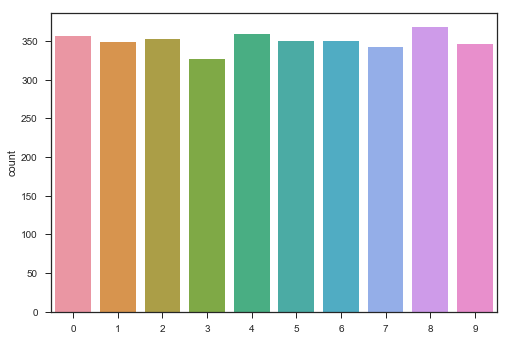

In [43]:
sns.countplot(y_train_all.ravel())

('label: ', 3)


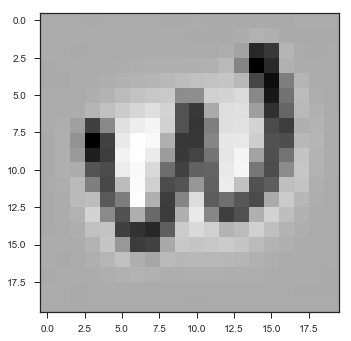

In [44]:
some_digit = X_train_all[5]
some_digit_image = some_digit.reshape(20, 20)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
print('label: ', y_train_all[5])

Split train set into training and validation

In [45]:
def split_train_val(X, y, ratio_train, state):
    # shuffle the sequence
    np.random.seed(state)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_train_val(X_train_all, y_train_all, 0.8, state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2800, 400), (700, 400), (2800,), (700,))

3.Initialize parameters (It is done when the class object created)

In [56]:
net = NeuralNet_Tu(size_tuple=(400, 200, 100, 40, 10))
for name_W, name_b in zip(net.param_W, net.param_b):
    print name_W, ': ', net.param_W[name_W].shape
    print name_b, ': ', net.param_b[name_b].shape

W4 :  (40, 10)
b4 :  (10,)
W3 :  (100, 40)
b1 :  (200,)
W2 :  (200, 100)
b2 :  (100,)
W1 :  (400, 200)
b3 :  (40,)


Question 4,5,6 are all in the following codes

Create a baseline for optimization:
1. Net Size: (400, 25, 10)
2. Activation: ReLu
3. Regularization: 0
4. Mini-Batch Size: Full Bacth
5. Learning Rate: 1

In [64]:
net_base = NeuralNet_Tu(size_tuple=(400, 25, 10))
net_base.train(X_train, y_train, X_val, y_val, num_iters=3500, learning_rate=1, verbose=True, 
               printstep=350, activation='relu', reg=0, batch_size=X_train.shape[0])

iteration 1 / 3500: loss 7.350597 train_acc  0.135714 val_acc 0.121429


iteration 350 / 3500: loss 0.524572 train_acc  0.936071 val_acc 0.901429


iteration 700 / 3500: loss 0.359757 train_acc  0.956786 val_acc 0.912857


iteration 1050 / 3500: loss 0.272483 train_acc  0.970357 val_acc 0.912857


iteration 1400 / 3500: loss 0.214042 train_acc  0.980000 val_acc 0.911429


iteration 1750 / 3500: loss 0.171982 train_acc  0.987500 val_acc 0.912857


iteration 2100 / 3500: loss 0.140496 train_acc  0.993214 val_acc 0.912857


iteration 2450 / 3500: loss 0.116697 train_acc  0.995000 val_acc 0.914286


iteration 2800 / 3500: loss 0.098490 train_acc  0.996786 val_acc 0.915714


iteration 3150 / 3500: loss 0.084330 train_acc  0.998214 val_acc 0.917143


iteration 3500 / 3500: loss 0.073125 train_acc  0.998571 val_acc 0.915714



Baseline validation accuracy 0.92

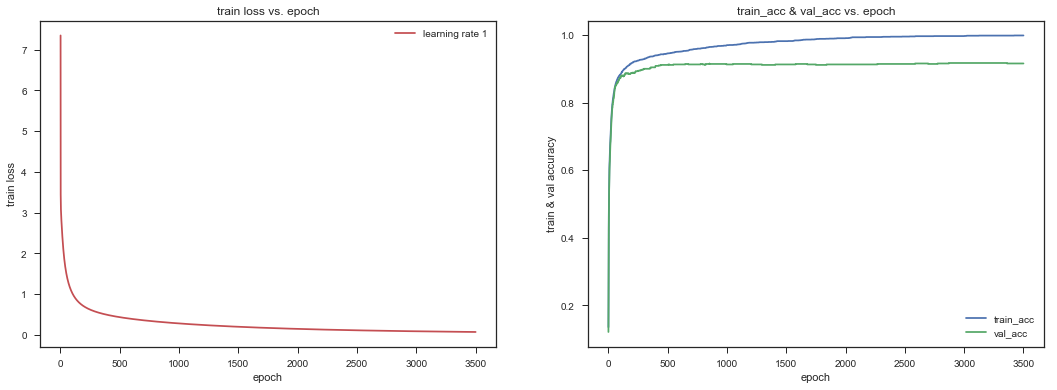

In [65]:
net_base.plot_loss_acc()

Optimization 1: Batch size

In [67]:
batch_size = [32, 64, 128, 256, 512, 1024]
train_time = []
train_acc = []
val_acc = []
for i in range(len(batch_size)):
    print('batch size: ', batch_size[i])
    net_batch = NeuralNet_Tu(size_tuple=(400, 25, 10))
    net_batch.train(X_train, y_train, X_val, y_val, num_iters=5000, learning_rate=1, verbose=False, 
                   printstep=50, activation='relu', reg=0, batch_size=batch_size[i], early_stop=1e-4)
    train_time.append(net_batch.train_time)
    train_acc.append(net_batch.train_acc_history[-1])
    val_acc.append(net_batch.val_acc_history[-1])

('batch size: ', 32)


('train loss diff is smaller than ', 0.0001, ', training stopped,', ' training time: ', 5.049428, 's')
('batch size: ', 64)


('train loss diff is smaller than ', 0.0001, ', training stopped,', ' training time: ', 4.439716, 's')
('batch size: ', 128)


('train loss diff is smaller than ', 0.0001, ', training stopped,', ' training time: ', 5.359524, 's')
('batch size: ', 256)


('train loss diff is smaller than ', 0.0001, ', training stopped,', ' training time: ', 7.541541, 's')
('batch size: ', 512)


('train loss diff is smaller than ', 0.0001, ', training stopped,', ' training time: ', 8.503144, 's')
('batch size: ', 1024)


('train loss diff is smaller than ', 0.0001, ', training stopped,', ' training time: ', 13.326813, 's')


Text(0.5,1,u'train_acc & val_acc vs. epoch')

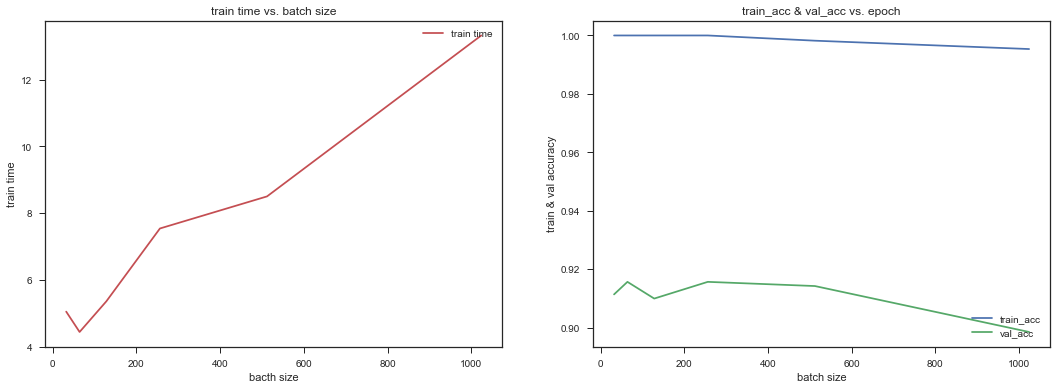

In [68]:
plt.figure(figsize=(18, 6))

# plot loss vs. epoch
plt.subplot(121)
plt.plot(batch_size, train_time, 'r-', label='train time')
plt.xlabel('bacth size')
plt.ylabel('train time')
plt.legend(loc='upper right')
plt.title('train time vs. batch size')

# plot train_acc & val_acc vs. epoch
plt.subplot(122)
plt.plot(batch_size, train_acc, 'b-', label='train_acc')
plt.plot(batch_size, val_acc, 'g-', label='val_acc')
plt.xlabel('batch size')
plt.ylabel('train & val accuracy')
plt.legend(loc='lower right')
plt.title('train_acc & val_acc vs. epoch')

batch size choose 64 because of training speed and validation accuracy

optimization 2:neural network structure & size


I'm applying the geometric pyramid rule, choosing structrues with 1, 2, 3 hidden layers:
1. 1 hidden layer: (400, 65, 10)
2. 2 hidden layer: (400, 120, 40, 10)
3. 3 hidden layer: (400, 160, 65, 25, 10)
4. Note: # of hidden layers >= 2 is already enough to represent arbitrary decision boundary to arbitrary accuracy with rational activation functions

In [71]:
size = [(400, 65, 10), (400, 120, 40, 10), (400, 160, 65, 25, 10)]
for i in range(len(size)):  
    net_archi = NeuralNet_Tu(size_tuple=size[i])
    net_archi.train(X_train, y_train, X_val, y_val, num_iters=1000, learning_rate=1, verbose=False, 
                   printstep=100, activation='relu', reg=0, batch_size=64, early_stop=1e-5)
    print('net archi: ', size[i], ' val_acc: ', net_archi.val_acc_history[-1])

('train loss diff is smaller than ', 1e-05, ', training stopped,', ' training time: ', 14.915546, 's')
('net archi: ', (400, 65, 10), ' val_acc: ', 0.9242857142857143)


('train loss diff is smaller than ', 1e-05, ', training stopped,', ' training time: ', 21.984258, 's')
('net archi: ', (400, 120, 40, 10), ' val_acc: ', 0.9328571428571428)


('train loss diff is smaller than ', 1e-05, ', training stopped,', ' training time: ', 23.517441, 's')
('net archi: ', (400, 160, 65, 25, 10), ' val_acc: ', 0.9357142857142857)


1. After more specific verifications(doesn't show here), due to the val_acc, I choose the net architechure 2 hidden layer(400, 120, 40, 10)
2. Please wait when running this code, it takes time. Besdies, I turned the verbose off, but it will print the result.

optimization 3: Activation Functions
1. Sigmoid
2. ReLu
3. Leaky ReLu

In [72]:
activation = ['sigmoid', 'relu', 'leaky_relu']
for i in range(len(activation)):  
    net_act = NeuralNet_Tu(size_tuple=(400, 120, 40, 10))
    net_act.train(X_train, y_train, X_val, y_val, num_iters=400, learning_rate=1, verbose=False, 
                   printstep=100, activation=activation[i], reg=0, batch_size=64, early_stop=1e-5)
    print('activation: ', activation[i], ' val_acc: ', net_act.val_acc_history[-1])


('activation: ', 'sigmoid', ' val_acc: ', 0.9271428571428572)



('activation: ', 'relu', ' val_acc: ', 0.9314285714285714)


('train loss diff is smaller than ', 1e-05, ', training stopped,', ' training time: ', 0.723159, 's')
('activation: ', 'leaky_relu', ' val_acc: ', 0.9342857142857143)


After more test(dosen't show here), due to the val_acc, I will choose leaky_relu as the activation function. 

optimization 4: L2 Regularization
1. 10 values in range(1e-5, 1e1)

In [74]:
reg = np.logspace(-5, 1, 10)
val_acc = []
for i in range(len(reg)):  
    net_reg = NeuralNet_Tu(size_tuple=(400, 120, 40, 10))
    net_reg.train(X_train, y_train, X_val, y_val, num_iters=100, learning_rate=1, verbose=False, 
                   printstep=10, activation='leaky_relu', reg=reg[i], batch_size=64, early_stop=1e-8)
    val_acc.append(net_reg.val_acc_history[-1])
    print('L2 lamda: ', reg[i], ' val_acc: ', net_reg.val_acc_history[-1])

('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.985052, 's')
('L2 lamda: ', 1e-05, ' val_acc: ', 0.9414285714285714)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.915581, 's')
('L2 lamda: ', 4.641588833612782e-05, ' val_acc: ', 0.9285714285714286)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.677386, 's')
('L2 lamda: ', 0.00021544346900318823, ' val_acc: ', 0.9371428571428572)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.392912, 's')
('L2 lamda: ', 0.001, ' val_acc: ', 0.9271428571428572)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.623699, 's')
('L2 lamda: ', 0.004641588833612777, ' val_acc: ', 0.9428571428571428)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.619919, 's')
('L2 lamda: ', 0.021544346900318822, ' val_acc: ', 0.9314285714285714)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.873095, 's')
('L2 lamda: ', 0.1, ' val_acc: ', 0.95)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.554236, 's')
('L2 lamda: ', 0.46415888336127725, ' val_acc: ', 0.9214285714285714)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.955814, 's')
('L2 lamda: ', 2.154434690031882, ' val_acc: ', 0.7914285714285715)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.230441, 's')
('L2 lamda: ', 10.0, ' val_acc: ', 0.07142857142857142)


Text(0.5,1,u'Lamda vs. Val_acc')

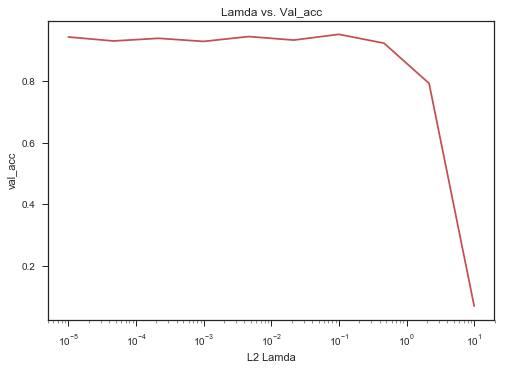

In [75]:
plt.semilogx(reg, val_acc, 'r-')
plt.xlabel('L2 Lamda')
plt.ylabel('val_acc')
plt.title('Lamda vs. Val_acc')

Based on the val_acc, shrink the range to test 2: (1e-2, 3e-1)

In [76]:
reg = np.logspace(-2, -0.5, 20)
val_acc = []
for i in range(len(reg)):  
    net_reg = NeuralNet_Tu(size_tuple=(400, 120, 40, 10))
    net_reg.train(X_train, y_train, X_val, y_val, num_iters=100, learning_rate=1, verbose=False, 
                   printstep=10, activation='leaky_relu', reg=reg[i], batch_size=64, early_stop=1e-8)
    val_acc.append(net_reg.val_acc_history[-1])
    print('L2 lamda: ', reg[i], ' val_acc: ', net_reg.val_acc_history[-1])

('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.731484, 's')
('L2 lamda: ', 0.01, ' val_acc: ', 0.93)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.799783, 's')
('L2 lamda: ', 0.011993539462092343, ' val_acc: ', 0.9457142857142857)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.62794, 's')
('L2 lamda: ', 0.01438449888287663, ' val_acc: ', 0.9357142857142857)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.687736, 's')
('L2 lamda: ', 0.017252105499420408, ' val_acc: ', 0.9357142857142857)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.391275, 's')
('L2 lamda: ', 0.0206913808111479, ' val_acc: ', 0.9357142857142857)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.64898, 's')
('L2 lamda: ', 0.024816289228368264, ' val_acc: ', 0.9542857142857143)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.521617, 's')
('L2 lamda: ', 0.029763514416313176, ' val_acc: ', 0.95)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.777291, 's')
('L2 lamda: ', 0.035696988468260644, ' val_acc: ', 0.9557142857142857)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.523763, 's')
('L2 lamda: ', 0.04281332398719394, ' val_acc: ', 0.9428571428571428)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.825701, 's')
('L2 lamda: ', 0.05134832907437552, ' val_acc: ', 0.9471428571428572)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.746532, 's')
('L2 lamda: ', 0.06158482110660264, ' val_acc: ', 0.9457142857142857)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.583779, 's')
('L2 lamda: ', 0.07386199822079359, ' val_acc: ', 0.9457142857142857)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 1.080489, 's')
('L2 lamda: ', 0.08858667904100823, ' val_acc: ', 0.9542857142857143)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 1.051526, 's')
('L2 lamda: ', 0.10624678308940409, ' val_acc: ', 0.9557142857142857)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 1.220912, 's')
('L2 lamda: ', 0.12742749857031335, ' val_acc: ', 0.9557142857142857)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.796156, 's')
('L2 lamda: ', 0.15283067326587688, ' val_acc: ', 0.9485714285714286)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.873634, 's')
('L2 lamda: ', 0.18329807108324356, ' val_acc: ', 0.9471428571428572)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.863838, 's')
('L2 lamda: ', 0.2198392648862289, ' val_acc: ', 0.9471428571428572)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.612936, 's')
('L2 lamda: ', 0.26366508987303583, ' val_acc: ', 0.9371428571428572)


('train loss diff is smaller than ', 1e-08, ', training stopped,', ' training time: ', 0.721014, 's')
('L2 lamda: ', 0.31622776601683794, ' val_acc: ', 0.9328571428571428)


Text(0.5,1,u'Lamda vs. Val_acc')

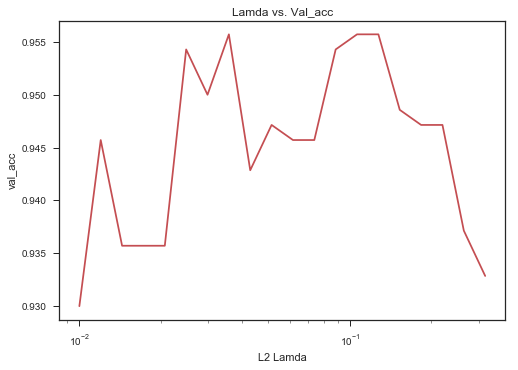

In [77]:
plt.semilogx(reg, val_acc, 'r-')
plt.xlabel('L2 Lamda')
plt.ylabel('val_acc')
plt.title('Lamda vs. Val_acc')

Based on the val_acc, I will choose L2 Lamda 0.1

Model 1:
1. L2: 0.1
2. activation: leaky_relu
3. batch_size: 64
4. learning_rate: 0.3
5. net_architecture: (400, 120, 40, 10)

In [78]:
net_final_test = NeuralNet_Tu((400, 120, 40, 10))
net_final_test.train(X_train, y_train, X_val, y_val, num_iters=600, learning_rate=0.3, verbose=True, 
                printstep=60,activation='leaky_relu', reg=0.1, batch_size=64, early_stop=None)

iteration 1 / 600: loss 1.943989 train_acc  0.879286 val_acc 0.834286


iteration 60 / 600: loss 1.578736 train_acc  0.997143 val_acc 0.955714


iteration 120 / 600: loss 1.549140 train_acc  0.997500 val_acc 0.955714


iteration 180 / 600: loss 1.541817 train_acc  0.998929 val_acc 0.957143


iteration 240 / 600: loss 1.539290 train_acc  0.999286 val_acc 0.955714


iteration 300 / 600: loss 1.538453 train_acc  0.999286 val_acc 0.954286


iteration 360 / 600: loss 1.537878 train_acc  0.999286 val_acc 0.955714


iteration 420 / 600: loss 1.538131 train_acc  0.999286 val_acc 0.955714


iteration 480 / 600: loss 1.538685 train_acc  0.999286 val_acc 0.957143


iteration 540 / 600: loss 1.538518 train_acc  0.999286 val_acc 0.957143


iteration 600 / 600: loss 1.538084 train_acc  0.999286 val_acc 0.958571


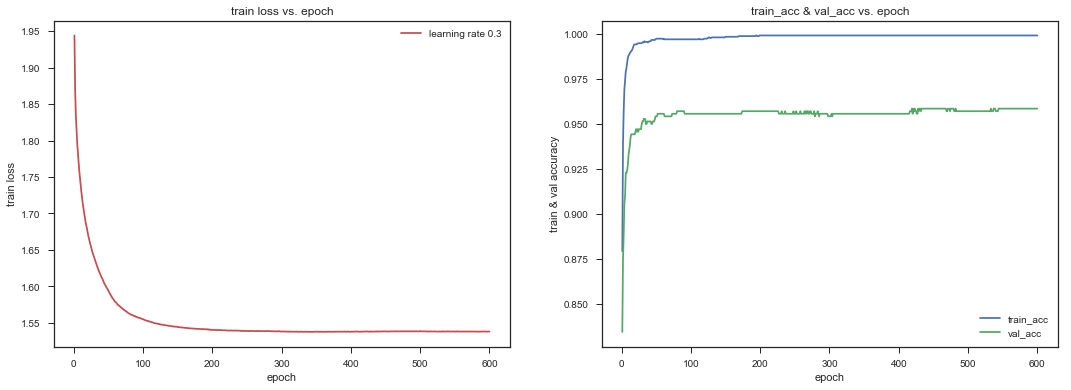

In [79]:
net_final_test.plot_loss_acc()

I will make it stop at epoch 400, train with full train set, then test

In [80]:
net_final = NeuralNet_Tu((400, 120, 40, 10))
net_final.train(X_train_all, y_train_all, num_iters=400, learning_rate=0.3, verbose=True, 
                printstep=100, activation='leaky_relu', reg=0.1, batch_size=64, early_stop=None)
test_pred = net_final.predict(X_test)
test_acc = np.mean(test_pred == y_test)
print('Final Test Accuracy: ', test_acc)

iteration 1 / 400: loss 1.996002 train_acc  0.904571


iteration 100 / 400: loss 1.562192 train_acc  0.998571


iteration 200 / 400: loss 1.555646 train_acc  0.999143


iteration 300 / 400: loss 1.555504 train_acc  0.999429


iteration 400 / 400: loss 1.554111 train_acc  0.999714
('Final Test Accuracy: ', 0.956)


Final test accuracy: 0.956, generally in range(0.950, 0.957). It improves a lot from the baseline validation accuracy 0.92
